["Conway's Gradient of Life"](https://hardmath123.github.io/conways-gradient.html) という記事に、ライフゲームを逆算する手法について書かれており、面白かったので私も自分で試してみることにしました。ライフゲームは、セル・オートマトンと呼ばれる2次元のグリッド上で動作するシミュレーションで、各セルは隣接するセルの状態に応じて次のステップでの生死の状態が決定します。ライフゲームを「逆算する」とは、ある特定のパターンに至る前の状態を推定することを意味します。つまり、1ステップ進めるとある形に収束する状態を、その形から逆に探し出す課題です。

今回は、ライフゲームのルールに基づいて1ステップ進めた時に、私のアイコンが現れるような初期状態を求めてみたいと思います。このテーマは以前、[Kaggleのコンペ](https://www.kaggle.com/c/conways-reverse-game-of-life-2020)でも扱われていたことがあったり、調べてみるといくつかのアプローチが存在します。例えば、[焼きなまし法を用いたもの](https://proc-cpuinfo.fixstars.com/2021/03/kaggle-conways-reverse-game-of-life-2020/)、[SMTソルバーを駆使したもの](https://www.youtube.com/watch?v=g8pjrVbdafY)、さらに[状態にベルヌーイ分布を仮定した確率モデルをMCMCで推定する方法](https://www2.stat.duke.edu/~sayan/561/2020/projects/writeup/Li,%20Dennis(dkl12@duke.edu)/Submission%20attachment(s)/solution.pdf)などがありました。

本稿では、基本的には元の記事と同じアプローチを取り、ライフゲームの時間発展に使用されているルールを微分可能な形式に緩和し、これを勾配降下法による最適化問題として解くことにします。

## ライフゲームの実装
ライフゲームのようなセル・オートマトンはコモナドを使って実装することができます。この話は以前[『コモナドを使った抽象化の威力をライフゲームで試してみた』](https://qiita.com/lotz/items/fbc4788b8ea8313cbf76)という記事に書きました。本稿でもその実装を使用するので詳しい仕組みの解説は記事に譲るとします。ただ記事の実装は無限に広がった盤面を仮定していたので、今回は有界で端が存在する盤面を扱うために以下の実装では適切な修正を加えています。

まずは盤面の基礎となるリストのZipperとその関数の実装です。

In [1]:
import Control.Comonad
import Data.List (unfoldr)

-- | List Zipper
data Z a = Z [a] a [a]
           deriving (Show, Functor, Foldable, Traversable)

instance Comonad Z where
  extract (Z _ a _) = a
  duplicate z = Z (iterate1 left z) z (iterate1 right z)
  extend f z = Z (f <$> iterate1 left z) (f z) (f <$> iterate1 right z)

-- | 注目している要素をひとつ左にずらす
left :: Z a -> Maybe (Z a)
left (Z [] _ _) = Nothing
left (Z (l:ls) c rs) = Just (Z ls l (c:rs))

-- | 注目している要素をひとつ右にずらす
right :: Z a -> Maybe (Z a)
right (Z _ _ []) = Nothing
right (Z ls c (r:rs)) = Just (Z (c:ls) r rs)

-- | 値を複製する
dup :: a -> (a, a)
dup x = (x, x)

-- | 関数を返り値がNothingになるまで繰り返し適用したリストを作成する関数
iterate1 :: (a -> Maybe a) -> a -> [a]
iterate1 f = unfoldr (fmap dup . f)

-- | リストから Z a に変換する
toZ :: [a] -> Z a
toZ [] = error "toZ can't take an empty list."
toZ (x:xs) = Z [] x xs

-- | Z a からリストに変換する
unZ :: Z a -> [a]
unZ (Z ls c rs) = ls ++ [c] ++ rs

-- | zip の Z a 版
zipZ :: Z a -> Z b -> Z (a, b)
zipZ (Z ls1 c1 rs1) (Z ls2 c2 rs2) = Z (zip ls1 ls2) (c1, c2) (zip rs1 rs2)

-- | zipWith の Z a 版
zipZWith :: (a -> b -> c) -> Z a -> Z b -> Z c
zipZWith f za zb = uncurry f <$> zipZ za zb

次に盤面の型となる `Z2 a` とその関数を実装します。

In [2]:
--   ライフゲームの盤面を表す型
newtype Z2 a = Z2 (Z (Z a))
           deriving (Show, Functor, Foldable, Traversable)

instance Comonad Z2 where
  extract (Z2 zz) = extract (extract zz)
  duplicate (Z2 zz) = fmap Z2 . Z2 . roll $ roll zz
    where
      roll zz = Z (iterate1 (mapM left) zz) zz (iterate1 (mapM right) zz)

-- | リストから Z2 a に変換する
toZ2 :: [[a]] -> Z2 a
toZ2 [] = error "toZ2 can't take an empty list."
toZ2 (x:xs) = Z2 (Z [] (toZ x) (map toZ xs))

-- | Z2 a からリストに変換する
unZ2 :: Z2 a -> [[a]]
unZ2 (Z2 (Z lzs cz rzs)) = map unZ lzs ++ [unZ cz] ++ map unZ rzs

-- | zipWith の Z2 a 版
zipZ2With :: (a -> b -> c) -> Z2 a -> Z2 b -> Z2 c
zipZ2With f (Z2 (Z lzs1 cz1 rzs1)) (Z2 (Z lzs2 cz2 rzs2)) =
  Z2 (Z (zipWith (zipZWith f) lzs1 lzs2)
        (zipZWith f cz1 cz2)
        (zipWith (zipZWith f) rzs1 rzs2))

`Z a` と `Z2 a` は後に自動微分で使いたいので `Traversable` のインスタンスまで導出しています。

最後にライフゲームの状態発展を計算する関数を実装しましょう

In [3]:
--   空リストに対する操作を安全にする関数
safe :: ([a] -> a) -> [a] -> Maybe a
safe f [] = Nothing
safe f xs = Just $ f xs

-- | 近傍の1列で生きているセルをカウントする関数
countNeighbour :: Bool  -- Trueなら中心もカウントする
               -> Z Bool
               -> Int
countNeighbour self (Z ls c rs) = length $ filter id [
  Just True == safe head ls,
  self && c,
  Just True == safe head rs
  ]

-- | 近傍で生きているセルをカウントする関数
countNeighbours :: Z2 Bool -> Int
countNeighbours (Z2 (Z lzs cz rzs)) = sum [
  maybe 0 (countNeighbour True) (safe head lzs),
  countNeighbour False cz,
  maybe 0 (countNeighbour True) (safe head rzs)
  ]

-- | 1セルにおけるライフゲームの状態発展
life :: Z2 Bool -> Bool
life z = (a && (n == 2 || n == 3)) || (not a && n == 3) where
  a = extract z
  n = countNeighbours z

コモナドのメソッド `extend` と1セルにおける状態発展の関数 `life` を使って、盤面全体の状態発展の関数は `extend life` と実装することができます。

実装したライフゲームを使って試しに[ブリンカー](https://ja.wikipedia.org/wiki/%E3%83%96%E3%83%AA%E3%83%B3%E3%82%AB%E3%83%BC_(%E3%83%A9%E3%82%A4%E3%83%95%E3%82%B2%E3%83%BC%E3%83%A0))を動かしてみましょう。

In [4]:
blinker :: Z2 Bool
blinker = toZ2 [[False, True, False], [False, True, False], [False, True, False]]

extend life blinker

Z2 (Z [] (Z [] False [False,False]) [Z [] True [True,True],Z [] False [False,False]])

In [5]:
extend life $ extend life blinker

Z2 (Z [] (Z [] False [True,False]) [Z [] False [True,False],Z [] False [True,False]])

ブリンカーのパタパタする様子が心の目で見えましたでしょうか。

`Z2 a` を標準の出力で確認するには限界があるので画像として扱えるようにしておきましょう。

In [6]:
import Codec.Picture

-- 二重リストを画像に変換する関数
stateToImage :: Z2 Bool -> Image Pixel8
stateToImage z2 = generateImage pixelRenderer width height
  where
    lst = unZ2 z2
    width = length (head lst)
    height = length lst
    pixelRenderer x y = pixelValue ((lst !! y) !! x)
    pixelValue x = if x then 0 else 255

In [7]:
stateToImage blinker

In [8]:
stateToImage $ extend life blinker

状態を1ピクセルにしたのでかなり小さいですが拡大して見て頂ければうまく動いてることがわかると思います。

## 画像の読み込み
ここからは今回ライフゲームで逆算するもととなる画像データを読み込んでいきます。画像データは "image.txt" というファイルに以下のような形式で用意しています。

In [9]:
take 100 <$> readFile "image.txt"

"w699b11w183b20w177b26w172b31w167b35w163b39w160b45w153b50w148b53w146b55w144b57w142b58w141b64w135b66w2"

これは200×200の0と1（白と黒）のビット列を一列にし白（w）が連続して何個並ぶかと黒（b）が連続して何個並ぶかという形式で圧縮したテキストファイルです。要するに画像を[ランレングス圧縮](https://ja.wikipedia.org/wiki/%E9%80%A3%E9%95%B7%E5%9C%A7%E7%B8%AE)したものです。今回の画像では生のテキストだと40KB, png画像形式で4KB, ランレングス圧縮だと3KBになり相性が良かったので採用しています。まずはこの圧縮された形式をデコードして画像ファイルに戻してあげましょう。

In [10]:
import Data.Char (isDigit)

-- | ランレングス圧縮された文字列をデコードする関数
decodeRLE :: String -> String
decodeRLE [] = []
decodeRLE (x:xs) =
  let (n, rest) = span isDigit xs
   in replicate (read n) x ++ decodeRLE rest

-- | 与えられたリストをN個ずつのチャンクに分ける関数
chunksOf :: Int -> [a] -> [[a]]
chunksOf _ [] = []
chunksOf n xs = take n xs : chunksOf n (drop n xs)

-- | 画像ファイルを読み込む
targetState <- (toZ2 . chunksOf 200 . map (=='b') . decodeRLE) <$> readFile "image.txt"

これで `targetState` に画像がライフゲームの状態として束縛されています。実際に見てみましょう。

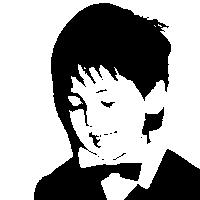

In [11]:
stateToImage targetState

うまく行っていますね。これはライフゲームの状態でもあるので1ステップ発展させてみましょう。

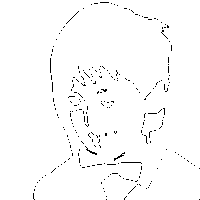

In [12]:
stateToImage $ extend life targetState

黒が多い部分は過密状態なのでセルが死んでしまっているのが分かりますね。

もう1,2ステップ時間発展させてみましょう。

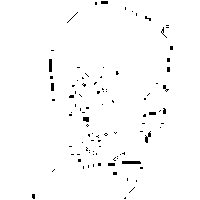

In [13]:
stateToImage $ extend life $ extend life targetState

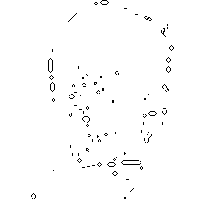

In [14]:
stateToImage $ extend life $ extend life $ extend life targetState

うわぁ… ライフゲームっぽくなってきましたね😅

## 微分可能なライフゲーム
さてここからはライフゲームの1つ前の状態を推定することを考えていきたいと思います。この問題を最適化問題として定式化するにあたって誤差関数を考えます。単純に入力となる状態 $Y$ を ${\rm life}$ 関数によって時間発展させたときにターゲットとなる画像 $X$ との差分の平均二乗誤差を誤差関数としましょう。

$$
L(Y) = \frac{1}{n}\|X - {\rm life}(Y)\|^2
$$

さてこの誤差を最小にするような $Y$ を見つけるためには $L$ を $Y$ で微分する必要がありますが、そのためには ${\rm life}$ が微分可能な関数である必要があります。しかし状態は真偽値であり ${\rm life}$ は論理式で構成されているため微分可能な関数ではありません。

そこでファジィ論理や確率論理と同様に真偽値を $[0, 1]$ の値として連続的に扱えるように拡張しましょう。その場合に論理式やプログラムの制御構文がどのように微分可能な形に拡張できるかについては ["The Elements of Differentiable Programming"](https://arxiv.org/abs/2403.14606) の5章 Control flows に詳細な記述があります。

例えば真偽値を $\{0, 1\}$ とすると2つの実数を比較して1つ目の数が2つ目の数より大きいかどうかを返す関数 ${\rm gt}(x, y)$ は

$$
\begin{matrix}
{\rm gt}(x, y) &=& \begin{cases}
1,\ {\rm if}\ x\geq y\\
0,\ {\rm otherwise}\\
\end{cases} \\
&=& {\rm step}(x-y)
\end{matrix}
$$

のように書けます。
ここで ${\rm step}$ 関数は以下のように定義されているものです。

$$
{\rm step}(x) = \begin{cases}
1,\ {\rm if}\ x \geq 0\\
0,\ {\rm otherwise} \\
\end{cases}
$$

これを $[0, 1]$ に値を取るように微分可能な形に緩和すると ${\rm step}$ 関数をシグモイド関数 ${\rm sigmoid}$ にするのがすぐに思いつく方法でしょう。

$$
{\rm sigmoid}_D(x) = \frac{1}{1+\exp\left(-\frac{x}{D}\right)}
$$

これを使って微分可能な形に緩和した比較関数 ${\rm gt}_D(x, y)$ を

$$
{\rm gt}_D(x, y) = {\rm sigmoid}_D(x-y)
$$

と定義します。実はシグモイド関数に置き換えたこの関数は変数がある確率分布に従うと仮定して期待値をとったものと解釈することも可能です。

同様の方法で"小なり"や"等号"に対応する関数を定義することも可能です。（先に挙げた["The Elements of Differentiable Programming"](https://arxiv.org/abs/2403.14606)で ${\rm lt}(x, y) = 1 - {\rm gt}(x, y)$ と定義されており、これだと後述する否定を使って ${\rm lt}(x, y) = {\rm not}({\rm gt}(x, y))$ と書けるため等号部分が異なる気がするのですが、この部分は微分可能な形に緩和すれば確率0で気にならなくなるので本稿でも同様に実装することにします。）

$[0, 1]$ に値を取る真偽値の論理演算子は以下のように定義することができます。

まず否定 ${\rm not}$ は0を1に、1を0に移すので単純に1からの減算と考えれるでしょう。

$$
{\rm not}(x) = 1 - x
$$

次に論理積 ${\rm and}(x, y)$ は $x, y$ いずれかの値が0なら0になり両方が1なら1になります。単純な積はこの性質を満たしていることがわかるでしょう。

$$
{\rm and}(x, y) = xy
$$

次に論理和 ${\rm or}(x, y)$ は $x, y$ いずれかの値が1なら1になり両方が0なら0になります。このような性質を満たす計算を見つけるのは簡単ではありませんが、既に否定と論理積があるのでド・モルガンの法則を使って

$$
\begin{matrix}
{\rm or}(x, y) &=& {\rm not}({\rm and}({\rm not}(x), {\rm not}(y))) \\
&=& 1 - (1-x)(1-y) \\
&=& x + y - xy \\
\end{matrix}
$$

のように定義できることが分かります。

このように論理和・論理積を $[0, 1]$ に拡張したものは代数和・代数積と呼ばれていて実は上記の定義以外にも無数に存在することが知られています。気になる人は以下を参照してみてください。

- [ファジィ理論とその応用 | Mathlog](https://mathlog.info/articles/145)
- [T-norm - Wikipedia](https://en.wikipedia.org/wiki/T-norm)

`if` などの制御構文も微分可能な形に実装することができますが、今回のライフゲームの実装では必要ありません。上記を参考に微分可能な比較演算子と論理演算子を実装してみましょう。

In [15]:
--   x > y
gtD :: Floating a => a -> a -> a
gtD x y = 1 / (1 + exp (-4 * (x - y)))

-- | x < y
ltD :: Floating a => a -> a -> a
ltD x y = 1 - gtD x y

-- | x == y
eqD :: Floating a => a -> a -> a
eqD x y = exp $ -(4 * (x - y))^2/2

-- | !x
notD :: Num a => a -> a
notD x = 1 - x

-- | x && y
andD :: Num a => a -> a -> a
andD x y = x * y

-- | x || y
orD :: Num a => a -> a -> a
orD x y = x + y - x * y

-- | x ≧ y
geqD :: Floating a => a -> a -> a
geqD x y = eqD x y `orD` gtD x y

-- | x ≦ y
leqD :: Floating a => a -> a -> a
leqD x y = eqD x y `orD` ltD x y

`gtD` と `ltD` は引数が一致する場合に値が $\frac{1}{2}$ となるため等号のない $>, <$ を表していると解釈し、等号も含めた演算子 $\geq, \leq$ を別途 `geqD, leqD` として実装しています。

それではこれらの演算子を使ってライフゲームの微分可能な状態発展を実装してみましょう。

In [16]:
import Data.Maybe (fromMaybe)

-- | 近傍の1列で生きているセルを合計する関数
sumNeighbour :: Num a
             => Bool  -- Trueなら中心もカウントする
             -> Z a
             -> a
sumNeighbour self (Z ls c rs) = sum [
  fromMaybe 0 (safe head ls),
  if self then c else 0,
  fromMaybe 0 (safe head rs)
  ]

-- | 近傍で生きているセルを合計する関数
sumNeighbours :: Num a
              => Z2 a
              -> a
sumNeighbours (Z2 (Z lzs cz rzs)) = sum [
  maybe 0 (sumNeighbour True) (safe head lzs),
  sumNeighbour False cz,
  maybe 0 (sumNeighbour True) (safe head rzs)
  ]

-- | 1セルにおけるライフゲームの微分可能な状態発展
lifeD :: Floating a => Z2 a -> a
lifeD z = (a `andD` (geqD n 2 `andD` leqD n 3)) `orD` (notD a `andD` eqD n 3)
  where
    a = extract z
    n = sumNeighbours z

`lifeD` の実装をよく見ると `Bool` に対する `life` の実装とよく対応していることが分かります。

```hs
life :: Z2 Bool -> Bool
life z = (a && (n == 2 || n == 3)) || (not a && n == 3) where
  a = extract z
  n = countNeighbours z
```

実際に `lifeD` を使ってライフゲームを状態発展させてみましょう。

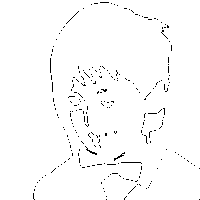

In [17]:
stateToImage $ fmap (> 0.5) $ extend lifeD $ (\b -> if b then 1.0 else 0.0) <$> targetState

先程見た結果と一致していそうですね。

## 1つ前の状態を推定する
それでは勾配降下法を使って目標となる画像に発展する1つ前の状態を求めてみましょう。入力となるセルの値が $[0,1]$ だと途中で範囲外に出てしまう可能性があるため、値は実数を取れるようにしてシグモイド関数で $[0, 1]$ に含まれるように変換することにします。自動微分には [ad](https://hackage.haskell.org/package/ad) ライブラリを使用しています。

initial, loss = 14174.446314774947
n = 0, loss = 12437.558591909137
n = 1000, loss = 669.9011793628988
n = 2000, loss = 581.6638456947436
n = 3000, loss = 547.3427997406984
n = 4000, loss = 524.5258231500682
n = 5000, loss = 511.03811378437507
n = 6000, loss = 500.1939355743127
n = 7000, loss = 489.87961196569944
n = 8000, loss = 484.3542493674258
n = 9000, loss = 479.40304896751013
n = 10000, loss = 476.66751555896707
n = 11000, loss = 474.38607336184685

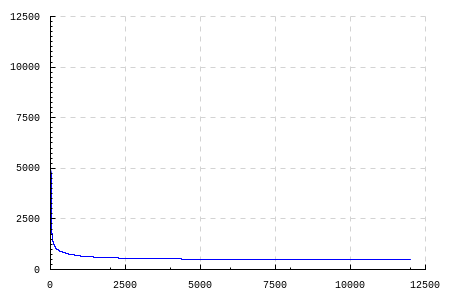

In [18]:
import Data.Function (fix)

import Graphics.Rendering.Chart.Easy
import Numeric.AD
import System.Random (randomIO)


(resultState, losses) <- do
  -- 初期状態をランダムに作成
  initialState <- toZ2 . chunksOf 200 . map (\b -> if b then 1 else -1) <$> sequence (replicate (200 * 200) randomIO)
  let -- ターゲットとなる画像を Z2 Float に変換
      target = (\b -> if b then 1 else 0) <$> targetState
      -- 定義域を [0, 1] から実数全体にするためシグモイド関数で変換する
      sigmoid x = 1 / (1 + exp (-x))
      -- 誤差関数
      loss state = sum . fmap (^2) $ zipZ2With (-) target (extend lifeD (fmap sigmoid state))
      -- エポック数
      epoch = 12000
  -- 初期値の誤差を表示する
  putStrLn $ concat ["initial, loss = ", show (loss target)]
  -- 勾配降下法で最適化を行う
  flip fix (initialState, epoch, []) $ \loop (state, n, losses) -> do
    if n == 0
      -- n が 0 になったら結果を整形して終了
      then pure (fmap sigmoid state, reverse losses)
      else do
        let -- 勾配降下法
            state' = zipZ2With (-) state (fmap (0.1*) (grad loss state))
            -- 誤差の評価
            !l = loss state'
        -- 定期的に進捗をログに出力する
        if mod n 1000 == 0
          then putStrLn $ concat ["n = ", show (epoch - n), ", loss = ", show l]
          else pure ()
        -- 状態を更新してループする
        loop (state', n-1, l:losses)

toRenderable $ plot (line "" [zip [0..] losses])

グラフから誤差を小さくできていることが分かりますね👏 ループの部分は[`flip fix` を使って](https://qiita.com/lotz/items/0894079a44e87dc8b73e)雑に書いていますが適切なfold系の関数を使って実装することも可能でしょう。

得られた結果がどうなっているか確認しましょう。

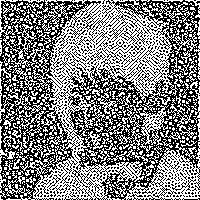

In [19]:
stateToImage $ fmap (> 0.5) resultState

既にかなり面影があります😅 これをライフゲームとして1ステップ状態発展させてみましょう。

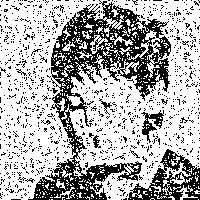

In [20]:
stateToImage $ extend life $ fmap (> 0.5) resultState

見事目標としていた画像に近いパターンが得られています。

ライフゲームのルール上黒いベタ塗りなどは表現しにくいのですが、[元記事](https://hardmath123.github.io/conways-gradient.html)でも指摘されているように1つ前の状態としてチューリング・パターンのような模様が現れているのは不思議ですよね👀